# Calculate and Plot Phasor Plots

In this notebook, we open a 2D FLIM image, build a phasor plot and apply some median filters to it.

## Set data path

In [51]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from FLIM_phasor import *
from readPTU_FLIM import PTUreader
import pandas as pd
import napari
from napari.utils import nbscreenshot
from skimage import filters, morphology, segmentation

In [2]:
data_path = r"D:\Datasets\FLIM\ptu_files\single slice\raw_FLIM_data\single_FLIM_image.ptu"
# data_path = "C:/Users/cblei/Desktop/miniSabb_local/FLIM_file_formats/single_FLIM_image.ptu"

In [3]:
data_path = Path(data_path)
print(data_path)

D:\Datasets\FLIM\ptu_files\single slice\raw_FLIM_data\single_FLIM_image.ptu


## Loading and formating FLIM data

Here we read a `.ptu` file from disk and pre-process it in order to have a 3D array where the first dimension is the microtime/photon counting. For more information, check the "Open_PTU_files" notebook.

In [5]:
ptu_file = PTUreader(data_path, print_header_data = False)

flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



We can read the pulsed laser frequency from the metadata. For `.ptu` files, this can be achieved by reading the following property:

In [6]:
laser_frequency = ptu_file.head['TTResult_SyncRate'] *1E-6 #MHz

We then create a time array and get the time step based on the laser frequency and the number of points in the data.

In [9]:
time_array = create_time_array(laser_frequency, n_points = flim_data_stack_for_napari.shape[0])
time_step = time_array[1] # ns
time_step

0.09494241742383244

In this example, we do not have a IRF (instrument impulse response function), therefore, for simplicity, we will skip the deconvolution step and just get the time points from the maximum value of the whole image onwards.

In [11]:
heights, bin_edges = np.histogram(np.ravel(np.argmax(flim_data_stack_for_napari, axis=0) * time_step), bins=time_array)
start_index = np.argmax(heights[1:]) + 1
start_index

12

Below we plot the image average intensity over time, highlighting the starting point. All earlier points are discarded from the analysis. The `time_mask` is a 1D binary array that indicates which time points should be considered.

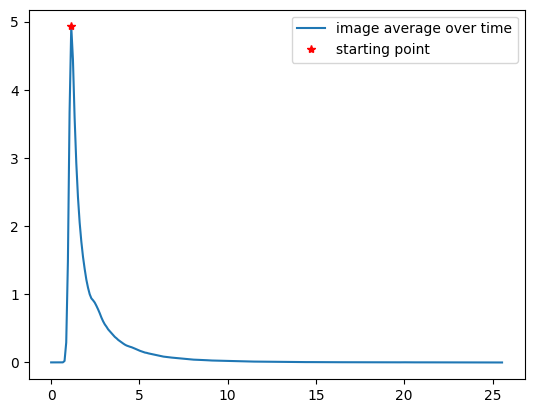

In [12]:
mean_intensity = np.mean(flim_data_stack_for_napari, axis=(1,2))
plt.plot(time_array, mean_intensity, label = 'image average over time')

time_mask = time_array >= time_array[start_index]
plt.plot(time_array[start_index], mean_intensity[start_index], 'r*', label = 'starting point')
plt.legend()

## Phasor Plot

### Apply threshold 

It is usually helpful to apply a threshold over the summed intensity image and calculate the Fourier Transform only for above the threshold pixels. This reduces noise in the phasor plot from pixel where photon collection was very low. The `space_mask` is a 2D binary mask that indicates which pixels should be considered.

In [19]:
threshold = 43

space_mask = intensity_image > threshold
threshold

43

### Reference decay lines
One can optionally add reference decay lines that are calculated from pure mono-exponential decay curves. Below, we define a list of decay/time constant values that we would like to see over the phasor plot.

In [20]:
tau_list = [0.5, 1, 2, 3, 4, 5, 6] #ns

### Plot Harmonics
We can also build phasor plots for different harmonics. Below, we display just the first 2 harmonics. To display higher harmonics, one can increase the `number_of_harmonics` value.

In [34]:
number_of_harmonics = 2

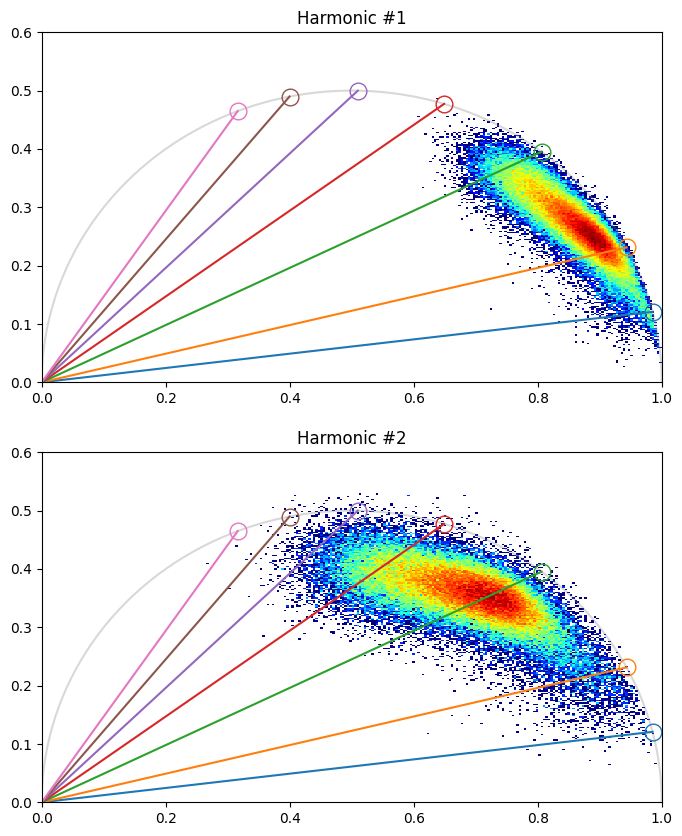

In [35]:
flim_image = flim_data_stack_for_napari
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply threshold
    x = np.ravel(g[space_mask])
    y = np.ravel(s[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)

### Apply space median filter
Consecutively applying a spatial median filter to g and s components can help to increase the resolution of the phasor plot. Below we apply it once and display the results.

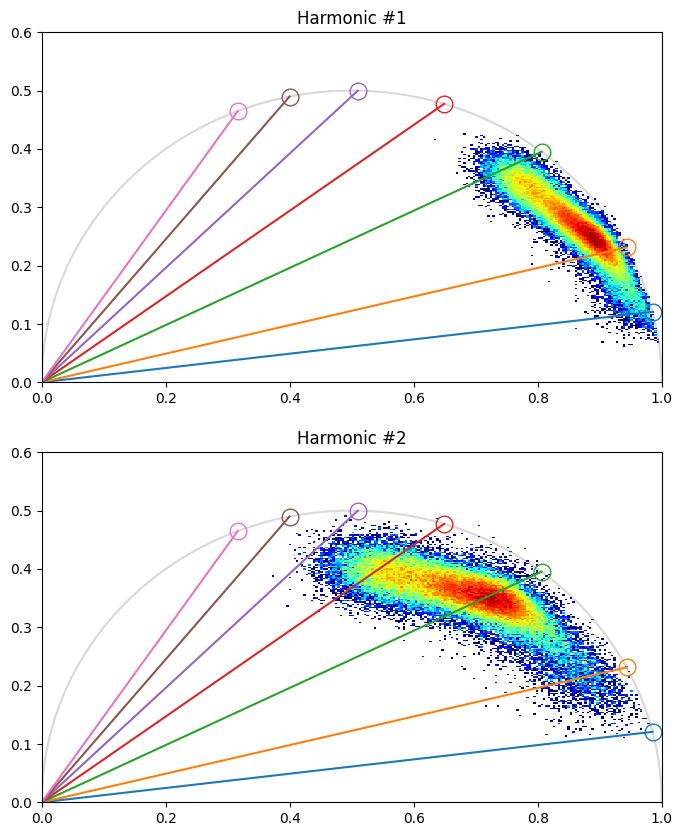

In [46]:
number_of_harmonics = 2
window_size = 3
footprint = morphology.square(3)


fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = i+1)

    # Apply median filter to g and s
    g_filt, s_filt = np.zeros_like(g), np.zeros_like(s)
    for j in range(g.shape[0]):
        g_filt[j] = filters.median(g[j])
        s_filt[j] = filters.median(s[j])

    # Apply threshold
    x = np.ravel(g_filt[space_mask])
    y = np.ravel(s_filt[space_mask])
    
    if number_of_harmonics == 1:
        current_axis = ax
    else:
        current_axis = ax[i]
    
    add_phasor_circle(current_axis)
    add_tau_lines(current_axis, tau_list, laser_frequency) 
    # current_axis.scatter(x,y, s=5, alpha=0.1, c='k')
    output = current_axis.hist2d(x, y, bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
    title = 'Harmonic #' + str(i+1)
    current_axis.set_title(title)

## Display in napari with napari-clusters-plotter

In [52]:
viewer = napari.Viewer()
viewer.add_image(flim_image)

<Image layer 'flim_image' at 0x213ace4df10>

In [53]:
g, s, dc = get_phasor_components(flim_image[time_mask], harmonic = 1)

label_image = np.arange(dc.shape[0]*dc.shape[1]).reshape(dc.shape) + 1
label_image[~space_mask] = 0
label_image = segmentation.relabel_sequential(label_image)[0]

phasor_components = {'label': np.ravel(label_image[space_mask]), 'G': np.ravel(g[space_mask]), 'S': np.ravel(s[space_mask])}
table = pd.DataFrame(phasor_components)

viewer.add_labels(label_image, features = table)

<Labels layer 'label_image' at 0x213b3f5eac0>

Open napari-clusters-plotter Plotter widget from "Tools -> Visualization -> Plot measurements (ncp)", choose `G` and `S` for "Axes", change from `SCATTER` to `HISTOGRAM` in "Advanced Options" and click on "Plot".

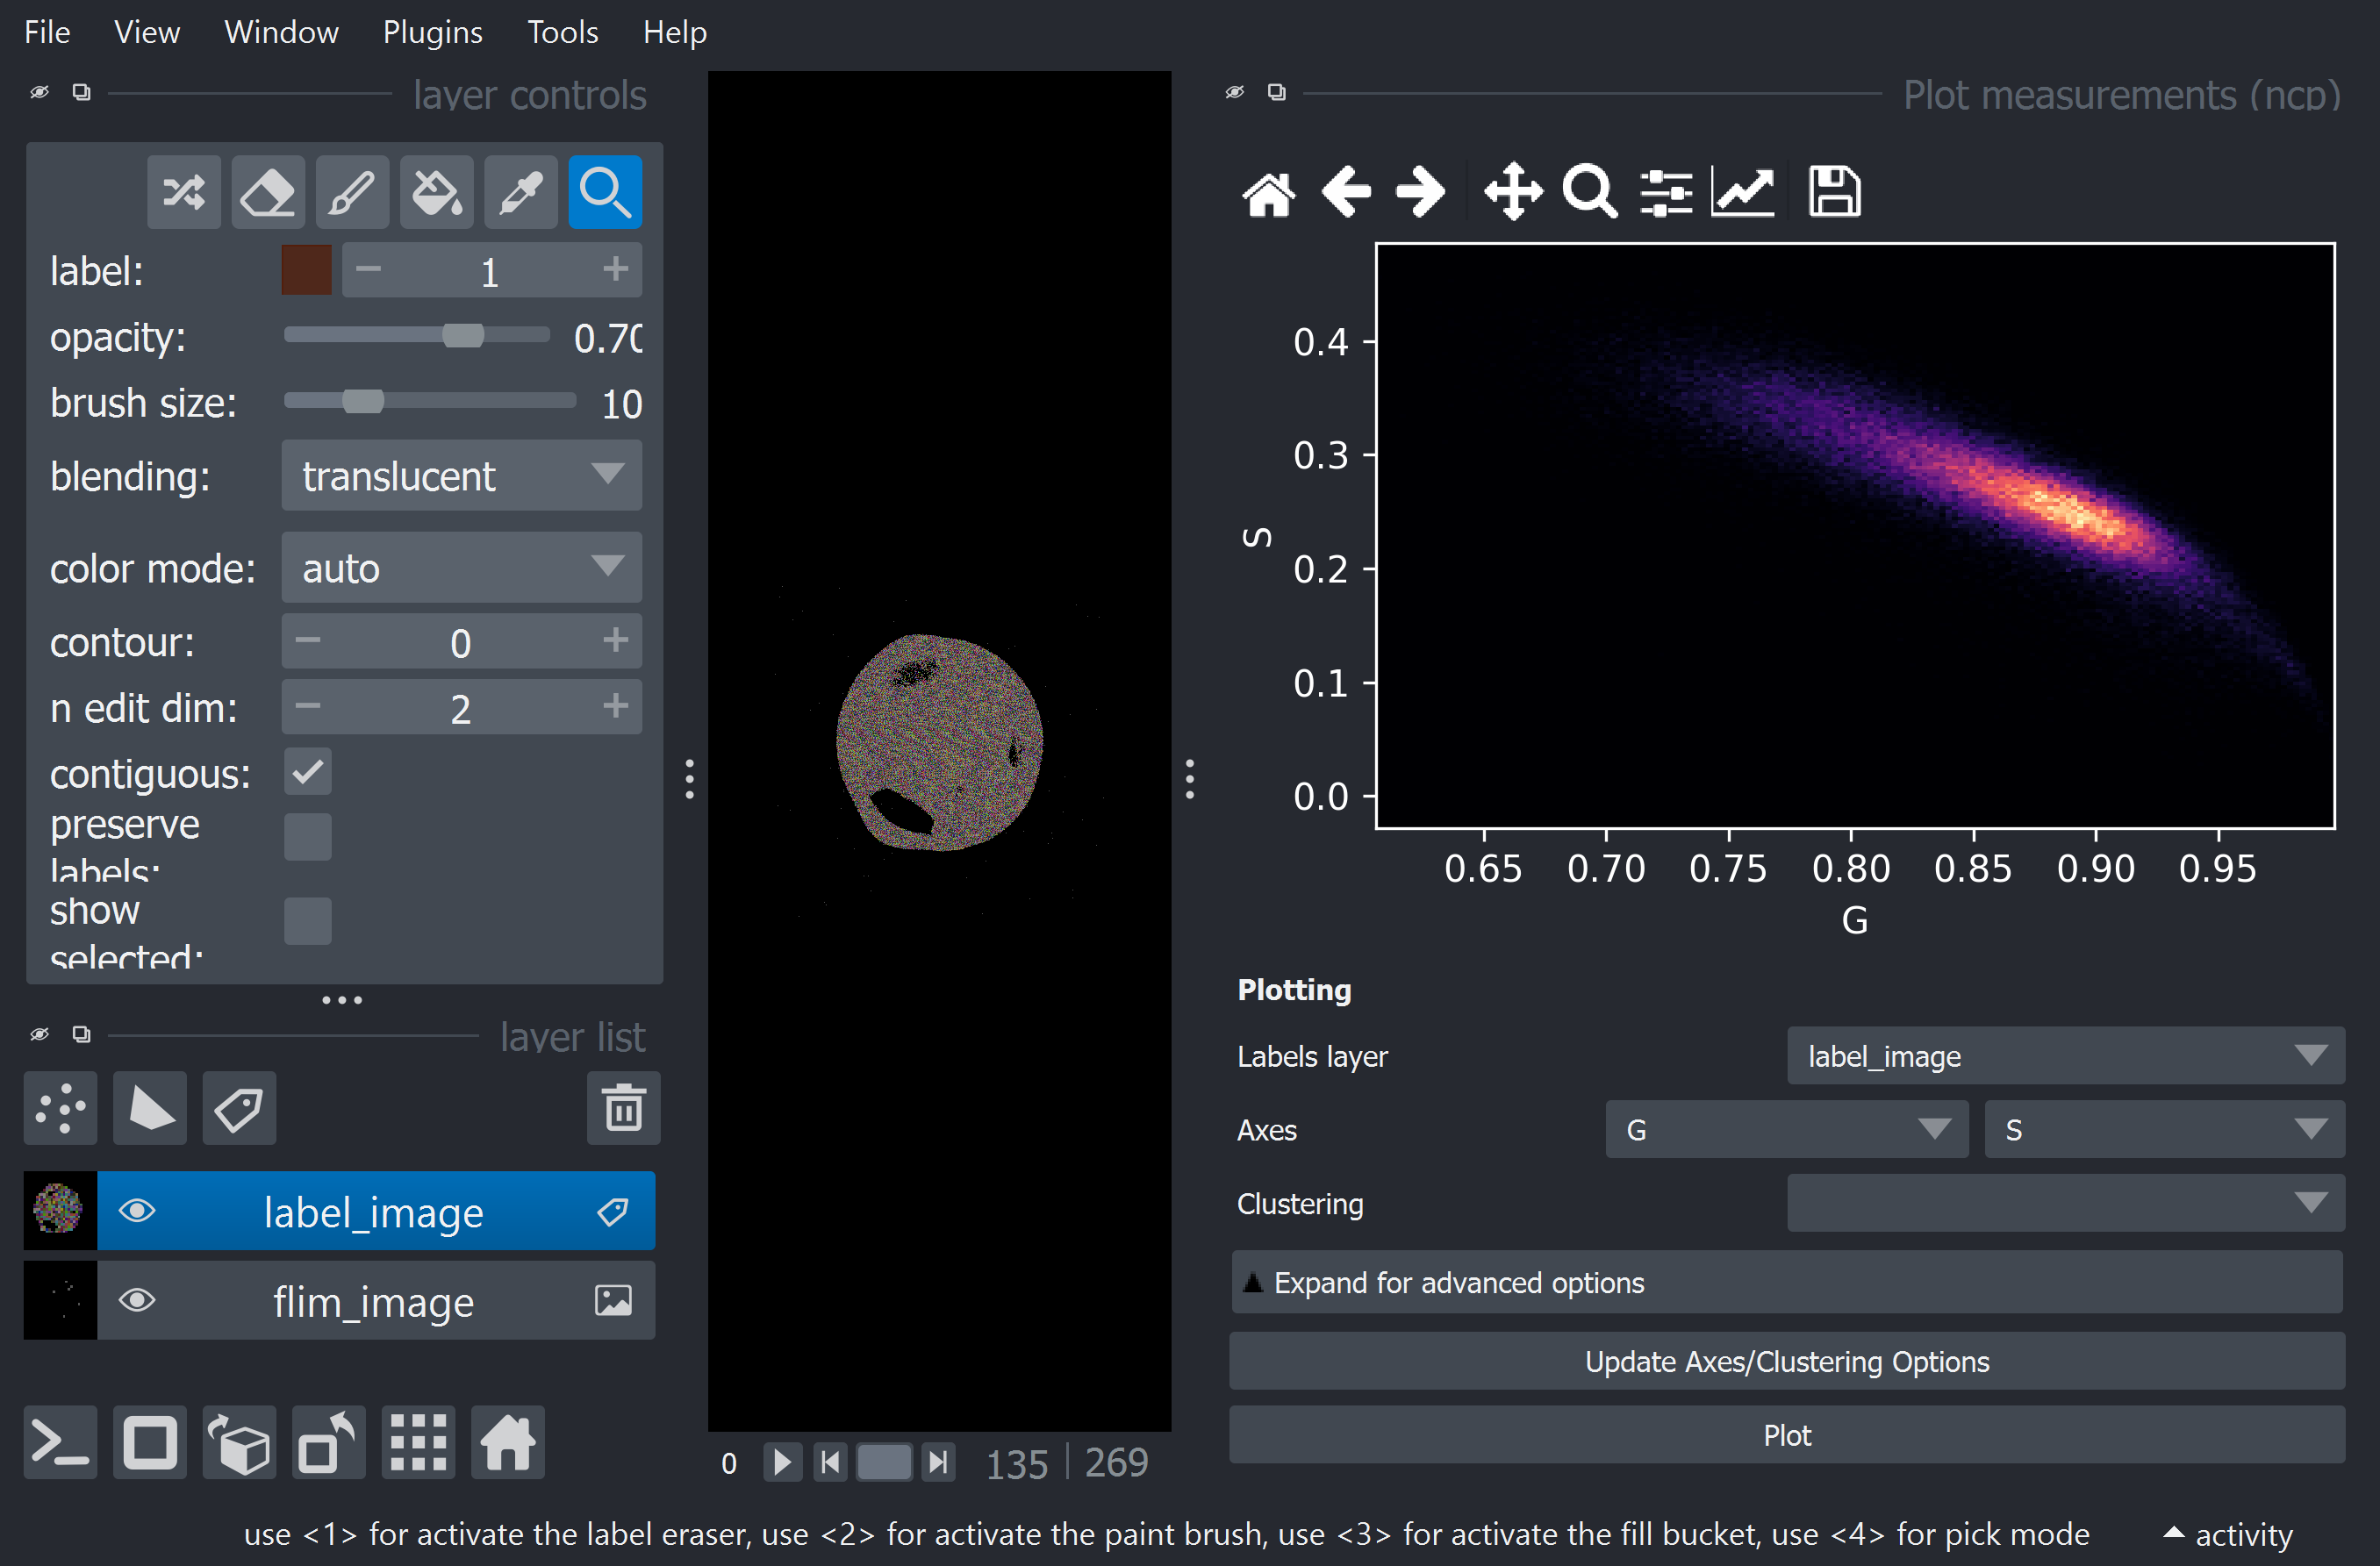

In [54]:
nbscreenshot(viewer)

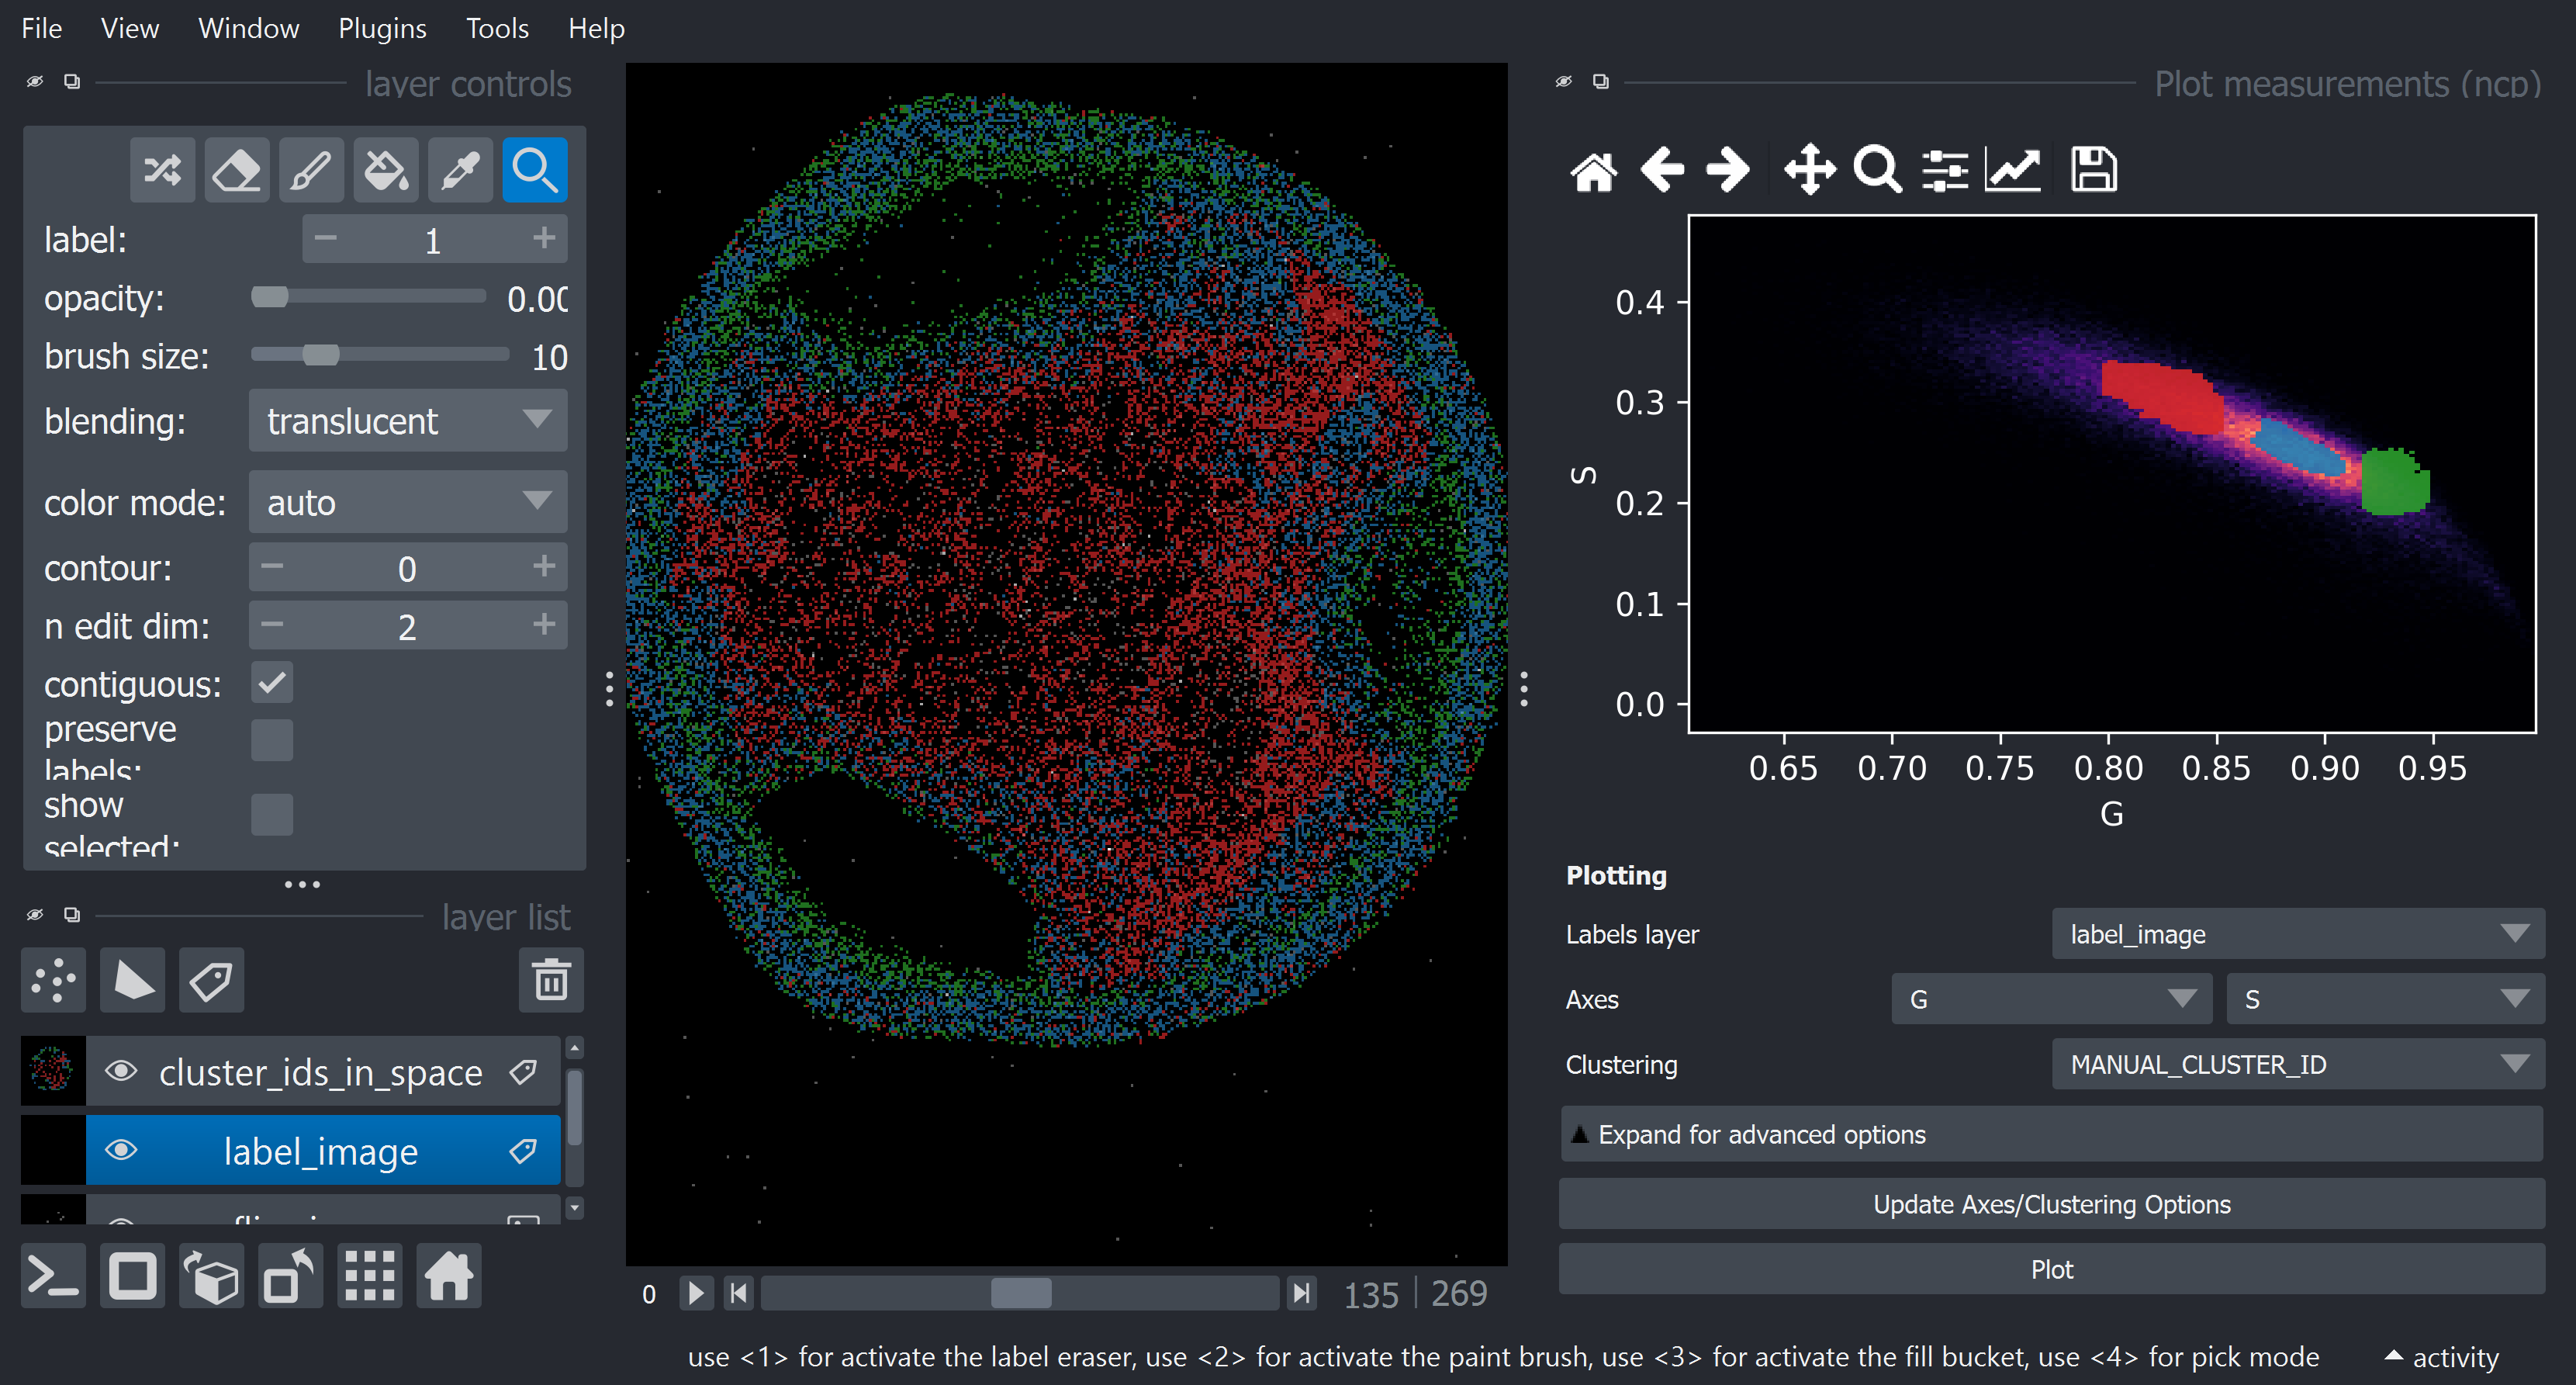

In [55]:
nbscreenshot(viewer)